In [1]:


import sys
import shap 
import pickle
import sklearn 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace 


In [2]:


# dc_all_m = pd.read_csv("../Datasets/dc_all_m.csv")
# dc_all_e = pd.read_csv("../Datasets/dc_all_e.csv")
# features_m = list(dc_all_m.iloc[:, 3:-1].columns)
# features_e = list(dc_all_e.iloc[:, 3:-1].columns)

# for i in range(len(features_e)):
#     try:
#         print(
#             " eGeMAPS:", features_e[i], 
#             "\n",
#             " GeMAPS:", features_m[i],
#         )
#     except:
#         print(
#             " eGeMAPS:", features_e[i], 
#             " GeMAPS: ------", 
#         )


In [3]:



sys.path.append("../Psychpy/")




In [4]:

from psychpy.data.psychiatric_data import PsychiatricData
from psychpy.data.preprocess import preprocess_data
from psychpy.models.regression_estimators import RegressionEstimators
from psychpy.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results




In [5]:

configs = {
    "results_path": Path("/home/soroosh/Programmes/Psychiatric_Disorders/Psychpy/results"),
    "figures_path": Path("/home/soroosh/Programmes/Psychiatric_Disorders/Psychpy/figures"),
    "params_path": Path("/home/soroosh/Programmes/Psychiatric_Disorders/Psychpy/params"),
    "n_repeats": 6,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [6]:

data_name="dc_all_e.csv"

estimator_name = "knn_reg"
to_shuffle = True
to_exclude_at_risk = 0
pp = "mm"


In [7]:

specifier = data_name + "-" + estimator_name + "--shuffled:" + str(to_shuffle)



In [8]:


configs.specifier = specifier
configs.data_name = data_name



In [9]:

configs.specifier



'dc_all_e.csv-knn_reg--shuffled:True'

## Load Data

In [10]:

psd = PsychiatricData(
    n_repeats=configs.n_repeats,
)

group_names = data_name.split("_")[0]
stimulus = data_name.split("_")[-1]

df_data_to_use = pd.read_csv(
    "/home/soroosh/Programmes/Psychiatric_Disorders/Datasets/"+ data_name 
)

df_data_to_use



,Unnamed: 0.1,Unnamed: 0,name,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,loudness_sma3_amean,loudness_sma3_stddevNorm,spectralFlux_sma3_amean,spectralFlux_sma3_stddevNorm,mfcc1_sma3_amean,...,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,depression.symptoms
0,0,0,PD-041,33.71559,0.274671,0.914548,0.720679,0.975441,1.001233,31.46796,...,-0.016040,0.234496,2.901628,1.066098,0.880667,0.817887,0.057778,0.072538,-19.03966,1.0
1,1,1,PD-137,32.80490,0.256112,1.065643,0.602840,0.866995,0.926338,23.53328,...,-0.012644,0.292435,1.446962,1.894827,0.448090,0.598150,0.074380,0.063509,-21.56311,1.0
2,2,2,PD-061,33.45501,0.257676,1.052321,0.771958,0.770251,1.190135,21.35476,...,-0.001670,0.304386,1.739671,2.146858,0.348261,0.689446,0.109016,0.090784,-22.68321,1.0
3,3,3,PD-002,28.71527,0.331356,0.704077,0.568861,0.581153,0.816479,26.78423,...,-0.011786,0.277511,3.918062,2.180635,0.382388,0.477652,0.070097,0.063529,-25.40923,1.0
4,4,4,PD-001,28.03393,0.335577,0.744879,0.674574,0.403177,1.065524,21.71391,...,-0.010081,0.284783,1.892430,2.062542,0.405645,0.505038,0.078409,0.059884,-27.77717,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,163,129,PN-248,37.29294,0.156502,0.983910,0.780023,0.701779,1.182353,10.58517,...,0.001949,0.190708,2.586406,1.982138,0.371105,0.380578,0.125487,0.212389,-21.79187,2.0
505,164,130,PN-234,34.98915,0.213354,0.548040,0.954184,0.343735,1.682461,26.44193,...,-0.003642,0.162634,2.010108,2.173163,0.220582,0.220807,0.228389,0.273057,-28.56736,2.0
506,165,131,PN-051,28.55805,0.253556,0.772317,0.859040,0.547673,1.231404,14.80711,...,-0.001743,0.152875,2.788061,2.163976,0.219679,0.181161,0.236296,0.417880,-23.20986,0.0
507,166,132,PN-266,32.84121,0.246333,0.656465,1.303577,0.586678,1.554338,14.73027,...,-0.000318,0.060232,2.719758,1.813978,0.251765,0.198612,0.289179,0.385705,-23.19289,1.0


In [11]:


indicators = ["name"]
targets = ["depression.symptoms"]

x_org, y_org = psd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=None,
    indicators=indicators,
    targets=targets,
)

x_org = x_org.drop(columns=['name', 'depression.symptoms'])
x = preprocess_data(x=x_org, pp=pp)  # only x is standardized
y = y_org["depression.symptoms"].values
assert not len(targets) > 1, f"more consideration is required to encode the target values {y.shape}!"




pre-processing: mm
Preprocessed data shape: (509, 46)


In [12]:

df_data_to_use.head()



,Unnamed: 0.1,Unnamed: 0,name,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,loudness_sma3_amean,loudness_sma3_stddevNorm,spectralFlux_sma3_amean,spectralFlux_sma3_stddevNorm,mfcc1_sma3_amean,...,slopeUV500-1500_sma3nz_amean,spectralFluxUV_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,depression.symptoms
0,0,0,PD-041,33.71559,0.274671,0.914548,0.720679,0.975441,1.001233,31.46796,...,-0.016040,0.234496,2.901628,1.066098,0.880667,0.817887,0.057778,0.072538,-19.03966,1.0
1,1,1,PD-137,32.80490,0.256112,1.065643,0.602840,0.866995,0.926338,23.53328,...,-0.012644,0.292435,1.446962,1.894827,0.448090,0.598150,0.074380,0.063509,-21.56311,1.0
2,2,2,PD-061,33.45501,0.257676,1.052321,0.771958,0.770251,1.190135,21.35476,...,-0.001670,0.304386,1.739671,2.146858,0.348261,0.689446,0.109016,0.090784,-22.68321,1.0
3,3,3,PD-002,28.71527,0.331356,0.704077,0.568861,0.581153,0.816479,26.78423,...,-0.011786,0.277511,3.918062,2.180635,0.382388,0.477652,0.070097,0.063529,-25.40923,1.0
4,4,4,PD-001,28.03393,0.335577,0.744879,0.674574,0.403177,1.065524,21.71391,...,-0.010081,0.284783,1.892430,2.062542,0.405645,0.505038,0.078409,0.059884,-27.77717,1.0


In [13]:

x_org.head()



,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,loudness_sma3_amean,loudness_sma3_stddevNorm,jitterLocal_sma3nz_amean,jitterLocal_sma3nz_stddevNorm,shimmerLocaldB_sma3nz_amean,shimmerLocaldB_sma3nz_stddevNorm,HNRdBACF_sma3nz_amean,HNRdBACF_sma3nz_stddevNorm,...,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength
0,33.71559,0.274671,0.914548,0.720679,0.062254,1.784175,1.324411,0.633371,6.732500,0.943398,...,-9.738769,15.597970,0.009914,-0.016040,2.901628,1.066098,0.880667,0.817887,0.057778,0.072538
1,32.80490,0.256112,1.065643,0.602840,0.059347,1.661850,1.132063,0.552007,4.658266,1.226140,...,-8.085348,13.909910,0.006504,-0.012644,1.446962,1.894827,0.448090,0.598150,0.074380,0.063509
2,33.45501,0.257676,1.052321,0.771958,0.041923,1.811098,1.254815,0.612553,4.691148,1.322853,...,-2.523753,7.602629,0.000892,-0.001670,1.739671,2.146858,0.348261,0.689446,0.109016,0.090784
3,28.71527,0.331356,0.704077,0.568861,0.078693,1.533510,1.595933,0.670735,3.878317,1.609681,...,-5.566400,11.963110,-0.004251,-0.011786,3.918062,2.180635,0.382388,0.477652,0.070097,0.063529
4,28.03393,0.335577,0.744879,0.674574,0.075207,1.526431,1.206214,0.698346,2.696220,2.222859,...,-3.590453,9.249436,0.014040,-0.010081,1.892430,2.062542,0.405645,0.505038,0.078409,0.059884


In [14]:



y_org



,depression.symptoms
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
504,2.0
505,2.0
506,0.0
507,1.0


In [15]:


x_org



,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,loudness_sma3_amean,loudness_sma3_stddevNorm,jitterLocal_sma3nz_amean,jitterLocal_sma3nz_stddevNorm,shimmerLocaldB_sma3nz_amean,shimmerLocaldB_sma3nz_stddevNorm,HNRdBACF_sma3nz_amean,HNRdBACF_sma3nz_stddevNorm,...,alphaRatioUV_sma3nz_amean,hammarbergIndexUV_sma3nz_amean,slopeUV0-500_sma3nz_amean,slopeUV500-1500_sma3nz_amean,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength
0,33.71559,0.274671,0.914548,0.720679,0.062254,1.784175,1.324411,0.633371,6.732500,0.943398,...,-9.738769,15.597970,0.009914,-0.016040,2.901628,1.066098,0.880667,0.817887,0.057778,0.072538
1,32.80490,0.256112,1.065643,0.602840,0.059347,1.661850,1.132063,0.552007,4.658266,1.226140,...,-8.085348,13.909910,0.006504,-0.012644,1.446962,1.894827,0.448090,0.598150,0.074380,0.063509
2,33.45501,0.257676,1.052321,0.771958,0.041923,1.811098,1.254815,0.612553,4.691148,1.322853,...,-2.523753,7.602629,0.000892,-0.001670,1.739671,2.146858,0.348261,0.689446,0.109016,0.090784
3,28.71527,0.331356,0.704077,0.568861,0.078693,1.533510,1.595933,0.670735,3.878317,1.609681,...,-5.566400,11.963110,-0.004251,-0.011786,3.918062,2.180635,0.382388,0.477652,0.070097,0.063529
4,28.03393,0.335577,0.744879,0.674574,0.075207,1.526431,1.206214,0.698346,2.696220,2.222859,...,-3.590453,9.249436,0.014040,-0.010081,1.892430,2.062542,0.405645,0.505038,0.078409,0.059884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,37.29294,0.156502,0.983910,0.780023,0.030797,1.878312,1.171222,0.706353,7.786119,0.699844,...,2.367108,4.306237,0.071468,0.001949,2.586406,1.982138,0.371105,0.380578,0.125487,0.212389
505,34.98915,0.213354,0.548040,0.954184,0.044269,2.266340,1.077491,0.980739,7.443884,0.844426,...,-5.732542,14.278940,-0.017107,-0.003642,2.010108,2.173163,0.220582,0.220807,0.228389,0.273057
506,28.55805,0.253556,0.772317,0.859040,0.056798,1.993284,1.266940,0.955530,5.024794,1.188593,...,-2.709044,10.505640,-0.006953,-0.001743,2.788061,2.163976,0.219679,0.181161,0.236296,0.417880
507,32.84121,0.246333,0.656465,1.303577,0.039705,1.703969,1.736068,0.676919,3.759959,1.452103,...,-9.924062,20.050840,-0.023690,-0.000318,2.719758,1.813978,0.251765,0.198612,0.289179,0.385705


In [16]:


estimator_name = "knn_reg"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)


learning_method: regression


In [17]:

x = preprocess_data(x=x_org, pp="mm")  # only x is standardized



pre-processing: mm
Preprocessed data shape: (509, 46)


In [18]:
x




array([[0.665, 0.491, 0.267, ..., 0.588, 0.024, 0.027],
       [0.626, 0.434, 0.337, ..., 0.398, 0.044, 0.022],
       [0.654, 0.438, 0.331, ..., 0.477, 0.087, 0.038],
       ...,
       [0.446, 0.426, 0.2  , ..., 0.038, 0.244, 0.234],
       [0.628, 0.403, 0.146, ..., 0.053, 0.309, 0.215],
       [0.65 , 0.245, 0.269, ..., 0.327, 0.203, 0.142]])

In [19]:


np.random.seed(43)

data = psd.get_stratified_train_test_splits(
        x=x, y=y,
        labels=y_org[targets].values,
        to_shuffle=to_shuffle,
        n_splits=configs.n_repeats
    )




In [20]:

data.keys()


dict_keys(['1', '2', '3', '4', '5', '6'])

## Load the tuned parameters OR weights

In [21]:

tuned_params = load_a_dict(
    name=configs.specifier,
    save_path=configs.params_path
        )
tuned_params


# dc_all_e.csv-knn_reg--shuffled:True


OrderedDict([('n_neighbors', 1), ('p', 1.0)])

In [23]:


mdl = sklearn.neighbors.KNeighborsRegressor(
   **tuned_params
)

mdl


KNeighborsRegressor(n_neighbors=1, p=1.0)

In [24]:


specifier



'dc_all_e.csv-knn_reg--shuffled:True'

In [25]:

k_ = "1"
x_train = data[k_]["x_train"]
x_test = data[k_]["x_test"]
y_train = data[k_]["y_train"]
y_test = data[k_]["y_test"]





In [26]:


y_test




array([1., 1., 1., 1., 1., 1., 1., 1., 0., 2., 1., 3., 1., 2., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 2., 1., 2., 0., 0., 2., 0., 0., 0.,
       0., 2., 0., 1., 1., 1., 1., 1., 1., 1., 2., 1., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 3., 3., 2., 2.])

In [27]:


# class_names = ['Control', 'At-risk', 'Dyslexic']



In [28]:

results = load_a_dict(
    name=configs.specifier,
    save_path=configs.results_path,
        )


r2, mae = [], []

for i in range(1, 11):
    i = str(i)
    y_test_ = results[i]["y_test"]
    y_pred_ = results[i]["y_pred"]
    
    tmp =  sklearn.metrics.r2_score(y_test_, y_pred_)
    r2.append(tmp)
    
    tmp2 = sklearn.metrics.mean_absolute_error(y_test_, y_pred_,)
    mae.append(tmp2)
  
    print(
        f"R2: {tmp: .3f}",
        
        f"MAE: {tmp2: .3f}"
    )




R2:  0.663 MAE:  0.137
R2:  0.612 MAE:  0.176
R2:  0.508 MAE:  0.216
R2:  0.896 MAE:  0.078
R2:  0.741 MAE:  0.078
R2:  0.974 MAE:  0.020
R2:  0.796 MAE:  0.078
R2:  0.694 MAE:  0.157
R2:  0.872 MAE:  0.098
R2:  0.637 MAE:  0.160


In [29]:

results[i]["y_pred"]
    


array([1., 1., 1., 1., 0., 1., 1., 1., 1., 2., 0., 0., 2., 0., 2., 0., 1.,
       1., 0., 0., 0., 1., 0., 3., 0., 1., 0., 0., 3., 0., 0., 0., 1., 1.,
       0., 0., 1., 1., 1., 1., 0., 1., 2., 0., 0., 2., 0., 0., 1., 1.])

In [30]:


y_test_




array([2., 1., 1., 1., 0., 1., 1., 0., 1., 2., 3., 0., 2., 0., 2., 0., 1.,
       1., 0., 0., 0., 1., 0., 3., 0., 1., 0., 0., 3., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 2., 0., 0., 2., 0., 0., 0., 1.])

In [31]:

r2 = np.asarray(r2)
r2.mean(), r2.std()




(0.7393903397283019, 0.13738283348205402)

In [32]:


mae = np.asarray(mae)
mae.mean(), mae.std()




(0.11992156862745099, 0.05598753087960405)

In [33]:


print_the_evaluated_results(
    results=results, 
    learning_method=learning_method
)




   mae     rmse  	 meape 	 r2_score 
 Ave   std  Ave   std   Ave   std   Ave   std 
0.120  ± 0.056 0.424 ± 0.136 6.971 ± 2.432 0.739 ± 0.137


In [34]:


mdl.fit(x_train, y_train)




KNeighborsRegressor(n_neighbors=1, p=1.0)

In [35]:

y_test[5:10:]

array([1., 1., 1., 0., 2.])

In [36]:


mdl.predict(x_test[5:10:, :])





array([1., 1., 1., 0., 2.])

In [37]:

sklearn.metrics.r2_score(y_test, 
                         mdl.predict(x_test)
                        )



0.8455668604651163

In [38]:


y_test




array([1., 1., 1., 1., 1., 1., 1., 1., 0., 2., 1., 3., 1., 2., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 3., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 2., 1., 2., 0., 0., 2., 0., 0., 0.,
       0., 2., 0., 1., 1., 1., 1., 1., 1., 1., 2., 1., 0., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0., 0., 0., 3., 3., 2., 2.])

In [39]:


len(list(x_org.columns)) == x_test.shape[1]




True

In [40]:

idx_0 = np.where(y_train==0.)[0]
idx_1 = np.where(y_train==1.)[0]
idx_2 = np.where(y_train==2.)[0]
idx_3 = np.where(y_train==3.)[0]



In [41]:


background = x_train # shap.sample(x_train, 500) # data to train both explainers on




In [42]:


background.shape


(424, 46)

In [43]:



explainer = shap.KernelExplainer(
    model=mdl.predict, 
    data=background,
    feature_names=list(x_org.columns), 
)

shap_values = explainer.shap_values(x_test,)




Using 424 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/85 [00:00<?, ?it/s]

In [45]:



print("Shap values are determined!")



Shap values are determined!


In [46]:


len(shap_values)


85

In [47]:


y_test.shape, x_test.shape, len(shap_values), shap_values[0].shape, 


((85,), (85, 46), 85, (46,))

In [48]:

shap_values.shape



(85, 46)

- what does row explain?  sorted features' importance in ascending order, low to high.
- what does each dot explain? data points
- what does color explain? data points per feature value

Interpret: 

- 

In [49]:


from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

RGB_val = 255

color01= (4,87,172)  # (0,255,255)  # Cyan wanted
color04= (244,230,4)  # (255,255,0)  # yellow wanted
Colors = [color01, color04]

# Creating a blue red palette transition for graphics
Colors= [(R/RGB_val,G/RGB_val,B/RGB_val) for idx, (R,G,B) in enumerate(Colors)]
n = 256

# Start of the creation of the gradient
Color01= ListedColormap(Colors[0], name='Color01', N=None)
Color04= ListedColormap(Colors[1], name='Color04', N=None)
top = cm.get_cmap(Color01,128)
bottom = cm.get_cmap(Color04,128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))

mymin0 = newcolors[0][0]
mymin1 = newcolors[0][1]
mymin2 = newcolors[0][2]
mymin3 = newcolors[0][3]
mymax0 = newcolors[255][0]
mymax1 = newcolors[255][1]
mymax2 = newcolors[255][2]
mymax3 = newcolors[255][3]

GradientBlueRed= [np.linspace(mymin0, mymax0,  n),
                   np.linspace(mymin1, mymax1,  n),
                   np.linspace(mymin2, mymax2,  n),
                   np.linspace(mymin3, mymax3,  n)]

GradientBlueRed_res =np.transpose(GradientBlueRed)

# End of the creation of the gradient

# newcmp = ListedColormap(GradientBlueRed_res, name='BlueRed')

# shap.summary_plot(shap_values, x_test, color=newcmp)

# Create colormap
newcmp = ListedColormap(GradientBlueRed_res, name='BlueRed')




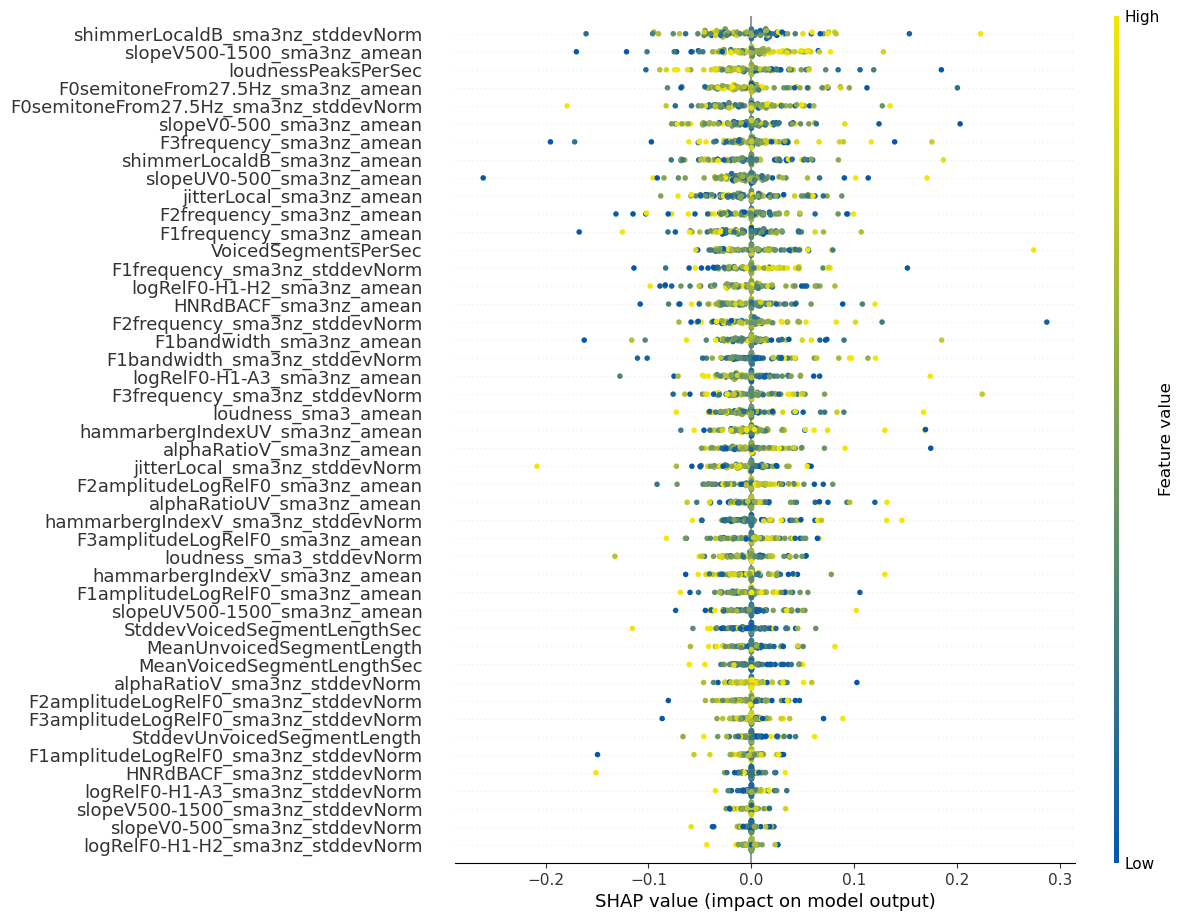

In [114]:


# Plot the summary without showing it
# plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values, x_test, 
                  show=False, 
                  plot_size=(10, 11),
                  feature_names=list(x_org.columns), 
#                   class_inds="original", 
                  class_names=[0, 1, 2, 3],
                  max_display=46
                 )

# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(newcmp)
            
# plt.savefig("summary_fix_demo.png")



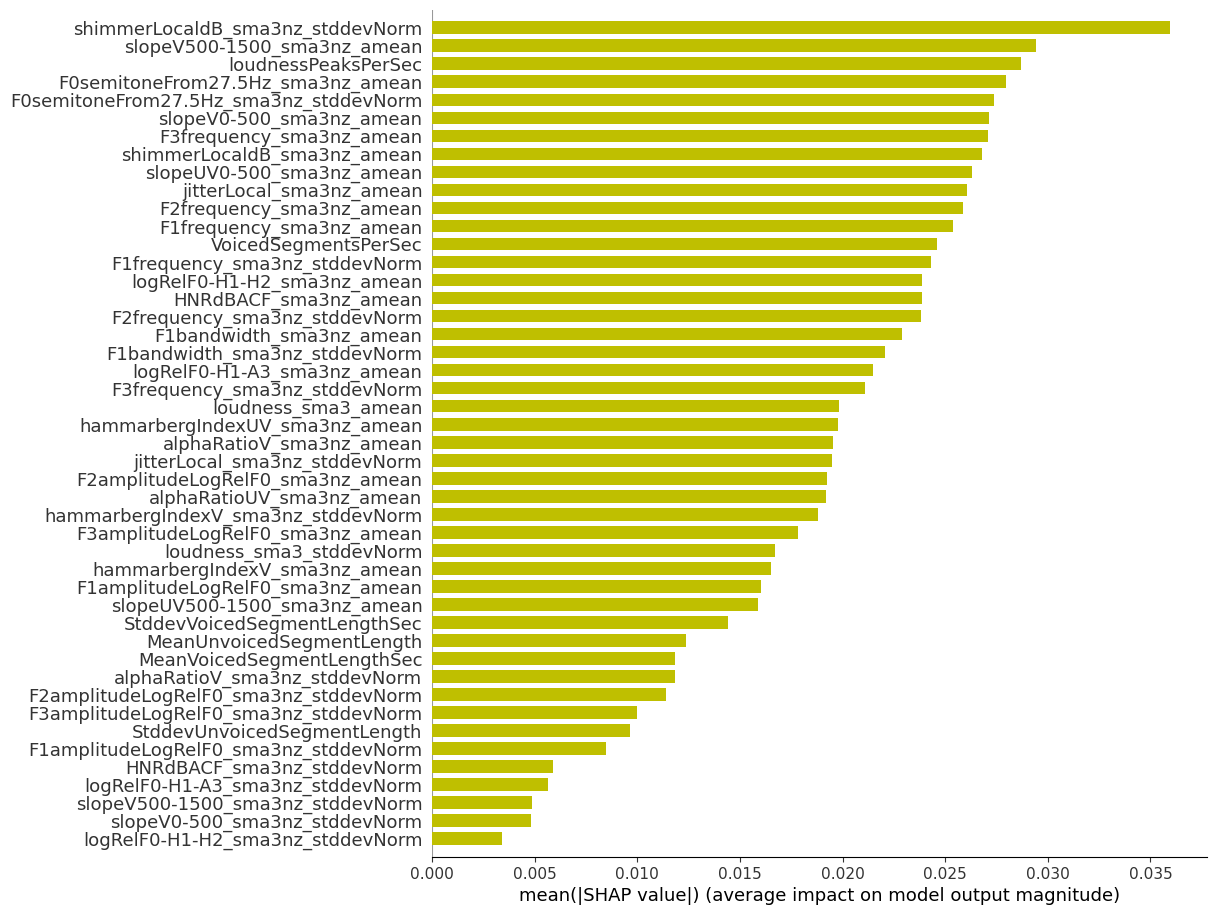

In [116]:


# plt.figure(figsize=(13, 10))
shap.summary_plot(shap_values, x_test, 
                  show=False, 
                  plot_size=(10, 11),
                  feature_names=list(x_org.columns), 
                  plot_type="bar",
                  color='y', 
                  max_display=46

                 )


In [71]:
len(list(x_org.columns))

46

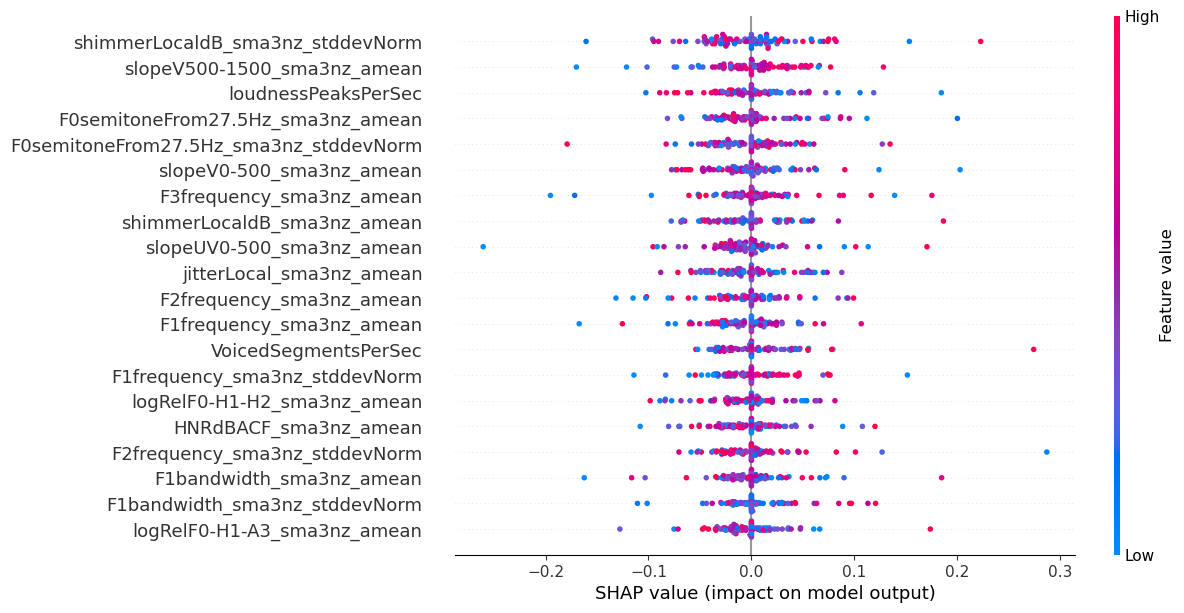

In [53]:
plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values, x_test, 
                  show=False, 
                  plot_size=(10, 7),
                  feature_names=list(x_org.columns), 
                  class_inds="original", 
#                   class_names=class_names,
#                   plot_type="scatter"
                 )

# # Change the colormap of the artists
# for fc in plt.gcf().get_children():
#     for fcc in fc.get_children():
#         if hasattr(fcc, "set_cmap"):
#             fcc.set_cmap(newcmp)
            
# plt.savefig("summary_fix_demo.png")



In [54]:


shap_values[0]



array([ 0.011,  0.014, -0.024,  0.   ,  0.009,  0.01 ,  0.   ,  0.03 ,
        0.013,  0.   ,  0.006, -0.005,  0.013,  0.017,  0.006,  0.017,
        0.006, -0.01 ,  0.01 ,  0.007,  0.019,  0.002,  0.016,  0.032,
        0.004,  0.003,  0.008,  0.004,  0.016,  0.   ,  0.008, -0.009,
       -0.005,  0.   ,  0.005,  0.004,  0.003,  0.005, -0.007,  0.   ,
       -0.021,  0.   ,  0.   ,  0.002,  0.   ,  0.002])

In [55]:


shap_values



array([[ 0.011,  0.014, -0.024, ...,  0.002,  0.   ,  0.002],
       [ 0.003,  0.02 , -0.015, ...,  0.   ,  0.014,  0.004],
       [ 0.003,  0.023, -0.006, ...,  0.007,  0.009,  0.01 ],
       ...,
       [ 0.087,  0.014,  0.167, ...,  0.035,  0.005,  0.   ],
       [ 0.043,  0.043,  0.   , ...,  0.013,  0.045,  0.   ],
       [ 0.074,  0.03 ,  0.043, ...,  0.043,  0.046,  0.   ]])

In [56]:


features = x_org.columns


In [57]:


mas_per_features = {}
for f in features:
    mas_per_features[f] = []
    



In [58]:


for f in range(len(features)): 
    tmp = np.mean(np.abs(shap_values[:, f]), axis=0)
#     print(f"{features[f]}:  {tmp:.3f}")
    mas_per_features[features[f]].append(tmp)
# print(" ")
    
    
    

In [59]:

sorted_mas_per_features = sorted(mas_per_features.items(), key=lambda x:x[1], reverse=True)
# sorted_mas_per_features



In [97]:
A = []

for k,v in sorted_mas_per_features:
#     b_ = (np.asarray(v).sum()*100/tot_)
    b_ = np.asarray(v).sum()

    print(
        f"Sum of MAS of {k} = {b_: .3f}  "
    )
    A.append(np.asarray(v).sum())
    
    
    
    
    

Sum of MAS of shimmerLocaldB_sma3nz_stddevNorm =  0.036  
Sum of MAS of slopeV500-1500_sma3nz_amean =  0.029  
Sum of MAS of loudnessPeaksPerSec =  0.029  
Sum of MAS of F0semitoneFrom27.5Hz_sma3nz_amean =  0.028  
Sum of MAS of F0semitoneFrom27.5Hz_sma3nz_stddevNorm =  0.027  
Sum of MAS of slopeV0-500_sma3nz_amean =  0.027  
Sum of MAS of F3frequency_sma3nz_amean =  0.027  
Sum of MAS of shimmerLocaldB_sma3nz_amean =  0.027  
Sum of MAS of slopeUV0-500_sma3nz_amean =  0.026  
Sum of MAS of jitterLocal_sma3nz_amean =  0.026  
Sum of MAS of F2frequency_sma3nz_amean =  0.026  
Sum of MAS of F1frequency_sma3nz_amean =  0.025  
Sum of MAS of VoicedSegmentsPerSec =  0.025  
Sum of MAS of F1frequency_sma3nz_stddevNorm =  0.024  
Sum of MAS of logRelF0-H1-H2_sma3nz_amean =  0.024  
Sum of MAS of HNRdBACF_sma3nz_amean =  0.024  
Sum of MAS of F2frequency_sma3nz_stddevNorm =  0.024  
Sum of MAS of F1bandwidth_sma3nz_amean =  0.023  
Sum of MAS of F1bandwidth_sma3nz_stddevNorm =  0.022  
Sum of

In [106]:
tot_ = sum(A)


for k,v in sorted_mas_per_features:
    b_ = (np.asarray(v).sum()*100/tot_)
    print(
        f"Sum of MAS of {k} = {b_: .3f}  "
    )
    
    
    

Sum of MAS of shimmerLocaldB_sma3nz_stddevNorm =  4.109  
Sum of MAS of slopeV500-1500_sma3nz_amean =  3.362  
Sum of MAS of loudnessPeaksPerSec =  3.276  
Sum of MAS of F0semitoneFrom27.5Hz_sma3nz_amean =  3.196  
Sum of MAS of F0semitoneFrom27.5Hz_sma3nz_stddevNorm =  3.129  
Sum of MAS of slopeV0-500_sma3nz_amean =  3.098  
Sum of MAS of F3frequency_sma3nz_amean =  3.093  
Sum of MAS of shimmerLocaldB_sma3nz_amean =  3.061  
Sum of MAS of slopeUV0-500_sma3nz_amean =  3.004  
Sum of MAS of jitterLocal_sma3nz_amean =  2.975  
Sum of MAS of F2frequency_sma3nz_amean =  2.953  
Sum of MAS of F1frequency_sma3nz_amean =  2.902  
Sum of MAS of VoicedSegmentsPerSec =  2.810  
Sum of MAS of F1frequency_sma3nz_stddevNorm =  2.775  
Sum of MAS of logRelF0-H1-H2_sma3nz_amean =  2.727  
Sum of MAS of HNRdBACF_sma3nz_amean =  2.727  
Sum of MAS of F2frequency_sma3nz_stddevNorm =  2.722  
Sum of MAS of F1bandwidth_sma3nz_amean =  2.617  
Sum of MAS of F1bandwidth_sma3nz_stddevNorm =  2.521  
Sum of

In [1]:
4.109   + 3.061  

7.17

In [99]:


for k, v in mas_per_features.items():
    print(
        f"Sum of MAS of {k} = {np.asarray(v)} "
    )
    
    
    

Sum of MAS of F0semitoneFrom27.5Hz_sma3nz_amean = [0.028] 
Sum of MAS of F0semitoneFrom27.5Hz_sma3nz_stddevNorm = [0.027] 
Sum of MAS of loudness_sma3_amean = [0.02] 
Sum of MAS of loudness_sma3_stddevNorm = [0.017] 
Sum of MAS of jitterLocal_sma3nz_amean = [0.026] 
Sum of MAS of jitterLocal_sma3nz_stddevNorm = [0.019] 
Sum of MAS of shimmerLocaldB_sma3nz_amean = [0.027] 
Sum of MAS of shimmerLocaldB_sma3nz_stddevNorm = [0.036] 
Sum of MAS of HNRdBACF_sma3nz_amean = [0.024] 
Sum of MAS of HNRdBACF_sma3nz_stddevNorm = [0.006] 
Sum of MAS of logRelF0-H1-H2_sma3nz_amean = [0.024] 
Sum of MAS of logRelF0-H1-H2_sma3nz_stddevNorm = [0.003] 
Sum of MAS of logRelF0-H1-A3_sma3nz_amean = [0.021] 
Sum of MAS of logRelF0-H1-A3_sma3nz_stddevNorm = [0.006] 
Sum of MAS of F1frequency_sma3nz_amean = [0.025] 
Sum of MAS of F1frequency_sma3nz_stddevNorm = [0.024] 
Sum of MAS of F1bandwidth_sma3nz_amean = [0.023] 
Sum of MAS of F1bandwidth_sma3nz_stddevNorm = [0.022] 
Sum of MAS of F1amplitudeLogRelF0_sm

In [100]:


# for f in range(len(features)):
#     shap.plots.scatter(shap_values[:, f])


